In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import random
import requests
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [ ]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform = ToTensor(),
    target_transform=None
)

In [ ]:
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform= None
)

In [ ]:
test_data.data.shape , train_data.data.shape

(torch.Size([10000, 28, 28]), torch.Size([60000, 28, 28]))

In [ ]:
class_label = train_data.class_to_idx
class_label

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

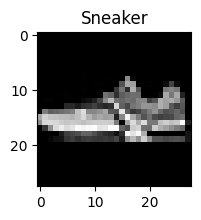

In [ ]:
# torch.manual_seed(42)
n = random.randint(0,len(train_data),)
image, label = train_data[n]
plt.figure(figsize=(2,2))

plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_name[label])
plt.show()

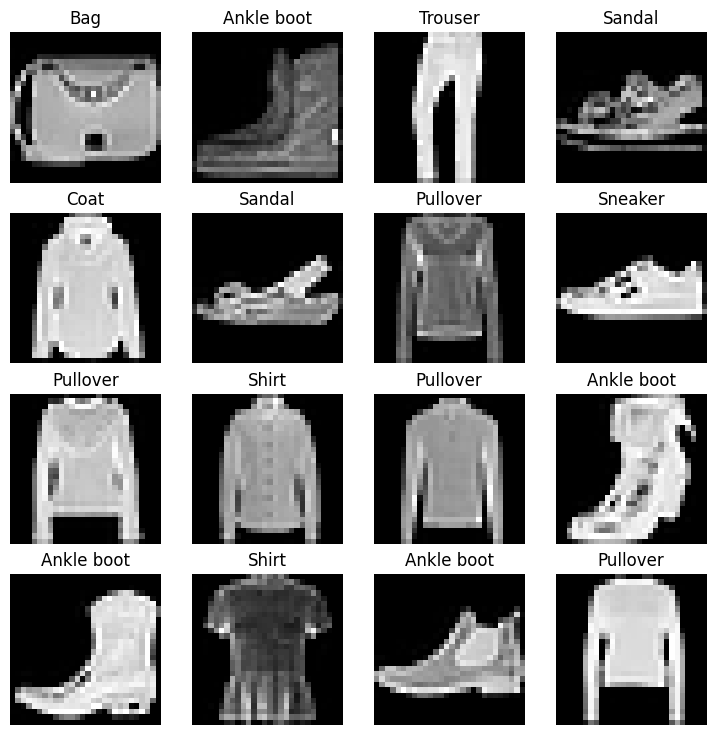

In [ ]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
row,col = 4,4

for i in range(1,row*col+1):
  # print(i)
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  img , label = train_data[random_idx]
  fig.add_subplot(row,col,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.title(class_name[label])
  plt.axis(False)

In [70]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size= BATCH_SIZE,
                              shuffle= True,
                  )

test_dataloader = DataLoader(test_data,
                             batch_size =BATCH_SIZE,
                             shuffle = False
                  )

In [71]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [72]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 1, 28, 28])

In [73]:
class FassionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape:int,
               output_shape:int,
               hidden_units:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape),
    )

  def forward(self,x):
    return self.layer_stack(x)


In [74]:
Model_baseline = FassionMNISTModelV0(input_shape=784,
                                     output_shape=10,
                                     hidden_units=10).to('cpu')

In [ ]:
Model_baseline

FassionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
if Path('helper_functions.py').is_file():
  print('Already Downloaded')
else:
  re = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open ('helper_functions.py','wb') as f:
    f.write(re.content)

Already Downloaded


In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_baseline.parameters(),
                            lr = 0.1)

In [ ]:
def print_train_time(start: int,
                     end: int,
                     device: torch.device = None):
  print(f'train time in this {device} is {end - start:0.3f}')
  return end - start

In [ ]:
torch.manual_seed(42)
total_start_train_time = timer()

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
  print(f'Epoch: {epoch}\n----')

  train_loss = 0
  accuracy = 0

  for batch, (X,y) in enumerate(train_dataloader):
    Model_baseline.train()

    X = X.to('cpu')
    y = y.to('cpu')
    y_pred=Model_baseline(X)
    loss = loss_fn(y_pred,y)
    acc = accuracy_fn(y,y_pred.argmax(dim=1))

    train_loss += loss
    accuracy += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400==0:

      print(f"Looked at {batch*len(X)} / {len(train_dataloader.dataset)}")

  train_loss /= len(train_dataloader)

  accuracy /= len(train_dataloader)

  test_loss ,test_acc = 0,0
  Model_baseline.eval()

  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      X_test = X_test.to('cpu')
      y_test = y_test.to('cpu')
      test_pred = Model_baseline(X_test)

      test_loss += loss_fn(test_pred, y_test)
      test_acc  += accuracy_fn(y_test, test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"Test Loss: {test_loss:0.3f}, Train Loss: {train_loss:0.3f} Train Accuracy {accuracy:0.3f}, Test Accuracy {test_acc:0.3f}")

total_end_train_time = timer()
total_time_baseline = print_train_time(total_start_train_time,
                                       total_end_train_time,
                                       device = 'cuda')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0 / 60000
Looked at 12800 / 60000
Looked at 25600 / 60000
Looked at 38400 / 60000
Looked at 51200 / 60000
Test Loss: 0.513, Train Loss: 0.594 Train Accuracy 78.870, Test Accuracy 82.039
Epoch: 1
----
Looked at 0 / 60000
Looked at 12800 / 60000
Looked at 25600 / 60000
Looked at 38400 / 60000
Looked at 51200 / 60000
Test Loss: 0.487, Train Loss: 0.477 Train Accuracy 83.277, Test Accuracy 82.808
Epoch: 2
----
Looked at 0 / 60000
Looked at 12800 / 60000
Looked at 25600 / 60000
Looked at 38400 / 60000
Looked at 51200 / 60000
Test Loss: 0.479, Train Loss: 0.455 Train Accuracy 84.010, Test Accuracy 83.466
train time in this cuda is 40.250


In [ ]:
torch.manual_seed(42)
def model_eval(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: str):
  loss,acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X= X.to(device)
      y= y.to(device)

      pred_y = model(X)
      loss_pred = loss_fn(pred_y,y)
      accuracy = accuracy_fn(y, pred_y.argmax(dim=1))

      loss +=loss_pred
      acc += accuracy
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {'model_name': model.__class__.__name__,
            'model_loss':loss.item(),
            'model_accuracy': acc}




In [ ]:
model_eval(Model_baseline,
           test_dataloader,
           loss_fn,
           accuracy_fn,
           'cpu')

{'model_name': 'FassionMNISTModelV0',
 'model_loss': 0.478794127702713,
 'model_accuracy': 83.46645367412141}

New Model